# Default Credit Card Prediction

## Week 1:- Identify DataSet and UseCase

### Use Case

This research aimed at the case of customers default payments in Taiwan and compares the predictive accuracy of probability of default among various data mining methods.

From the perspective of risk management, the result of predictive accuracy of the estimated probability of default will be more valuable than the binary result of classification - credible or not credible clients. In this tutorial we will look at how to predict defaulting, using Machine and Deep Learning techniques.

### Data Source

The dataset is available at https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

#### Attribute Information

This study uses 25 variables as explanatory variables, extracted/interpreted from : 
    
```
   ----------------------------------------------------------------------------------------
   Name                 Explantion        
   -------------------- -------------------------------------------------------------------
   limit_bal            Amount of the given credit (NT dollar): 
                        it includes both the individual consumer credit 
                        and his/her family (supplementary) credit.
   
   sex                  Gender 
                        (1 = male; 2 = female)
   
   education            Education
                        (1 = graduate school; 2 = university; 3 = high school; 4 = others)
   
   marriage             Marital status 
                        (1 = married; 2 = single; 3 = others)
   
   age                  Age (years)
   
   pay_1 - pay_6        History of past payment. Past monthly payment records 
                        From April to September, 2005 as follows:
                        
                        pay_1 = the repayment status in September, 2005
                        pay_2 = the repayment status in August, 2005
                        ...
                        pay_6 = the repayment status in April, 2005 
                        
                        The measurement scale for the repayment status is: 
                        -1 = pay duly; 
                        1 = payment delay for one month 
                        2 = payment delay for two months
                        ...
                        8 = payment delay for eight months 
                        9 = payment delay for nine months and above
                        
   bill_amt1-bill_amt5  Amount of bill statement (NT dollar). 
                        bill_amt1 = amount of bill statement in September, 2005 
                        bill_amt2 = amount of bill statement in August, 2005
                        ...
                        bill_amt6= amount of bill statement in April, 2005 
                        
   pay_amt1-pay_amt6    Amount of previous payment (NT dollar)
                        pay_amt1 = amount paid in September, 2005
                        pay_amt2 = amount paid in August, 2005
                        ...
                        pay_amt6 = amount paid in April, 2005 
   ----------------------------------------------------------------------------------------
```


##### Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import urllib
import wget
import xlrd
import shutil
import os
import re
from math import log


%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.neighbors.kde import KernelDensity
from patsy import dmatrices
import itertools
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")
#warnings.simplefilter(action='ignore', category=(UserWarning,RuntimeWarning))

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import Callback

Using TensorFlow backend.


Plot default settings

In [2]:
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.rcParams.update({'font.size': 10})
plt.rcParams['xtick.major.pad']='5'
plt.rcParams['ytick.major.pad']='5'

plt.style.use('ggplot')

##### Donwload and Read Data

In [ ]:
data_dir = './data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [ ]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default of credit card clients.xls'
file_name = os.path.join(data_dir, 'default of credit card clients.xls')

if not os.path.isfile(filename):
    wget.download(url, out=file_name)

In [3]:
file_name = 'default of credit card clients.xls'
os.chdir(r'C:\Srinu\AdvancedDataSciencewithIBM\AdvancedDataScienceCapstone')
data = pd.read_excel(file_name, header=1)

In [4]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
data.shape

(30000, 25)

##### Preprocessing or Data Cleansing

The following preprocessing and data cleansing activities performed

* Lower cased the columns
* Renamed the feature Pay_0 in to Pay_1
* ID attribute was dropped as its not required for this modeling
* Converted the attribute default payment next month type to category and stored the values in default which our target variable

In [6]:
data.columns = [x.lower() for x in data.columns]
data = data.rename(index=str, columns={"pay_0": "pay_1"})
data = data.drop('id', axis=1)
data.columns

Index(['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'default payment next month'],
      dtype='object')

In [7]:
# Rename the lable to default
data['default'] = data['default payment next month'].astype('category')

##### Descriptive Analysis

Analyse the **payment delay** features and understand them

In [8]:
pattern = re.compile("^pay_[0-9]+$")
pay_status_columns = [ x for x in data.columns if (pattern.match(x))]
data[pay_status_columns].head(10)

,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6
0,2,2,-1,-1,-2,-2
1,-1,2,0,0,0,2
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,-1,0,-1,0,0,0
5,0,0,0,0,0,0
6,0,0,0,0,0,0
7,0,-1,-1,0,0,-1
8,0,0,2,0,0,0
9,-2,-2,-2,-2,-1,-1


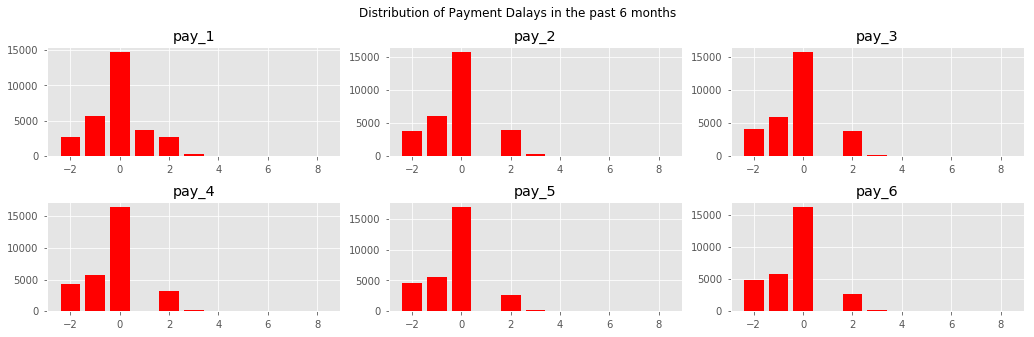

In [9]:
fig, ax = plt.subplots(2,3)
fig.set_size_inches(15,5)
fig.suptitle('Distribution of Payment Dalays in the past 6 months')

for i in range(len(pay_status_columns)):
    row,col = int(i/3), i%3

    d  = data[pay_status_columns[i]].value_counts()
    ax[row,col].bar(d.index, d, align='center', color='r')
    ax[row,col].set_title(pay_status_columns[i])

plt.tight_layout(pad=3.0, w_pad=0.5, h_pad=1.0)
plt.show()

From the above graphs we can interpreted that some people pay 2 month upfront, others one month upfront, most of them are on par. a few are running behind payments.

Now, let's look now at how the debts/credit is accumulating over the months, credit to be repaid is a positive number here.

In [10]:
# bill columns
pattern = re.compile("^bill_amt[0-9]+$")
bill_columns = [ x for x in data.columns if (pattern.match(x))]
data[bill_columns].head()

,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6
0,3913,3102,689,0,0,0
1,2682,1725,2682,3272,3455,3261
2,29239,14027,13559,14331,14948,15549
3,46990,48233,49291,28314,28959,29547
4,8617,5670,35835,20940,19146,19131


In [11]:
data[bill_columns].describe()

,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6
count,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000
mean,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400
std,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537
min,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000
25%,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000
50%,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000
75%,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000


##### Previous months payments

Look at how the payments are performed in the previous month.

In [12]:
# pay status columns
pattern = re.compile("^pay_amt[0-9]+$")
pay_amount_columns = [ x for x in data.columns if (pattern.match(x))]
data[pay_amount_columns].head()

,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
0,0,689,0,0,0,0
1,0,1000,1000,1000,0,2000
2,1518,1500,1000,1000,1000,5000
3,2000,2019,1200,1100,1069,1000
4,2000,36681,10000,9000,689,679


In [13]:
data[pay_amount_columns].describe()

,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
count,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


In [14]:
data['limit_bal'].describe()

count      30000.000000
mean      167484.322667
std       129747.661567
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: limit_bal, dtype: float64

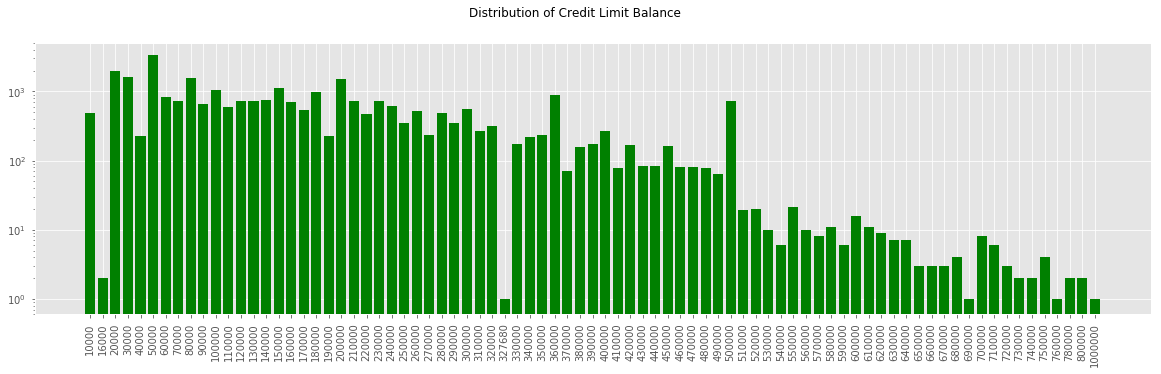

In [15]:
# limit balance
fig = plt.figure()
fig.set_size_inches(20,5)
fig.suptitle('Distribution of Credit Limit Balance')
ax = fig.add_subplot(111)

d = data.groupby(['limit_bal']).size()
ax.set_yscale("log")
ax.set_xticks(np.arange(len(d)))
ax.set_xticklabels(['%d' % i for i in d.index], rotation='vertical')
p = ax.bar(np.arange(len(d)), d, color='green')

Now lets explore the **default** label

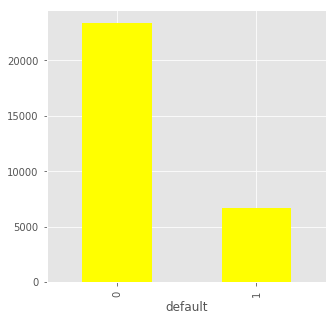

In [16]:
fig = plt.figure()
fig.set_size_inches(5,5)
d = data.groupby(['default']).size()
p = d.plot(kind='bar', stacked=True, color='yellow')
#p = d.plot(kind='barh', color='orange') #horizontal bar plot

In [17]:
print('Distribution of default values:\n', data.default.value_counts()/data.shape[0])

Distribution of default values:
 0    0.7788
1    0.2212
Name: default, dtype: float64


### Correlation coefficient of attributes

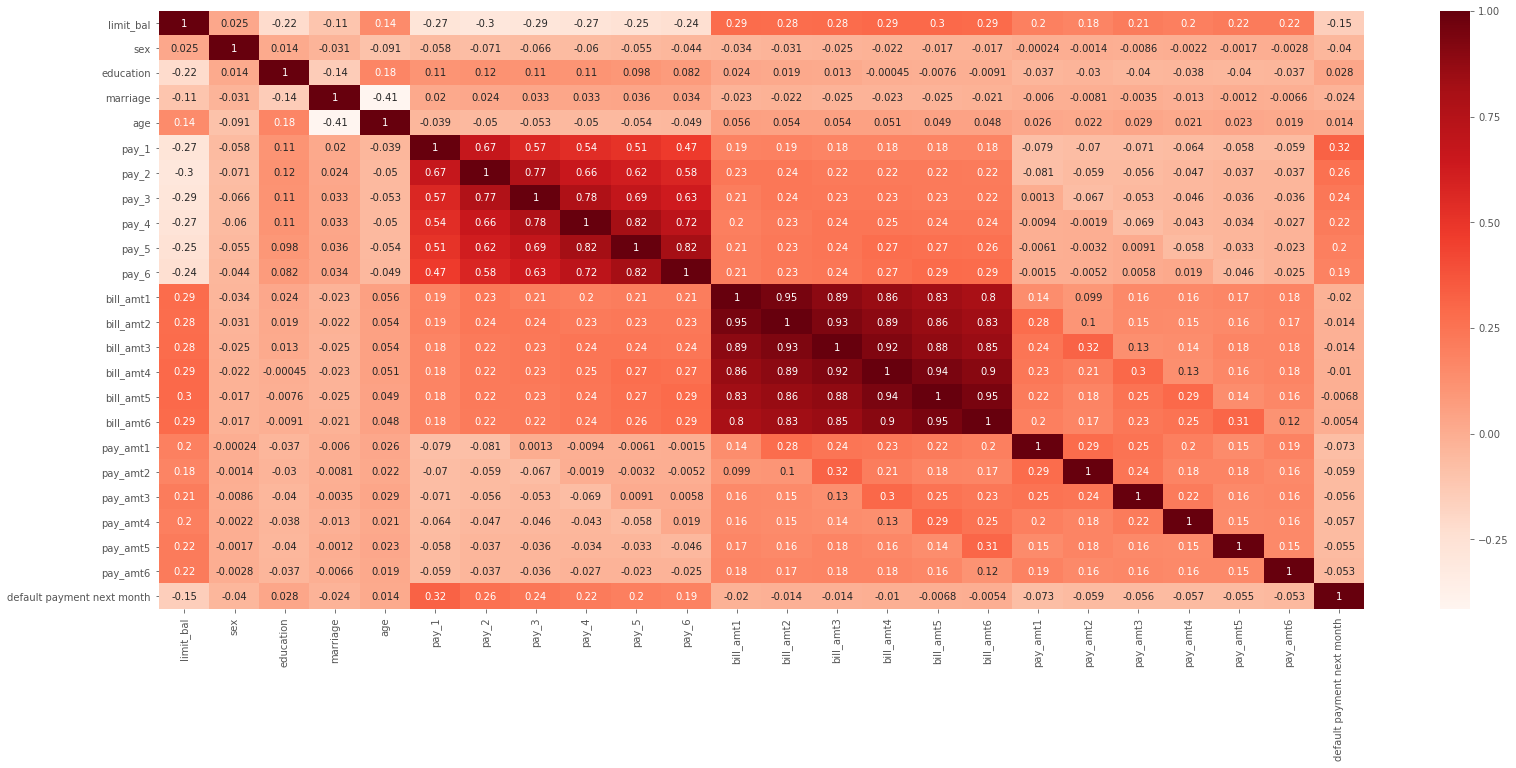

In [18]:
#Using Pearson Correlation
plt.figure(figsize=(27,11))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

The above correlation matrix represents how attributes correlated among each other and their strength of relationship. Pay_1 to Pay_6 features are reasonably positive correlation with the default.

##### Explore statistical analysis of the categorical variables

Look at a number of histograms to see how defaulting correlated with the categorical variables available, before that let's make use of categorical features of pandas, by converting target, sex, marriage, education, age and the pay_* columns to categories

In [19]:
data['sex'] = data['sex'].astype('category').cat.rename_categories(['M', 'F'])
data['marriage'] = data['marriage'].astype('category').cat.rename_categories(['na', 'married', 'single', 'other'])

In [20]:
data['age_cat'] = pd.cut(data['age'], range(0, 100, 10), right=False)

In [21]:
pattern = re.compile("^pay_[0-9]+$")
pay_status_columns = [ x for x in data.columns if (pattern.match(x))]
for i in pay_status_columns:
    data[i] = data[i].astype('category')

##### Absolute statistics

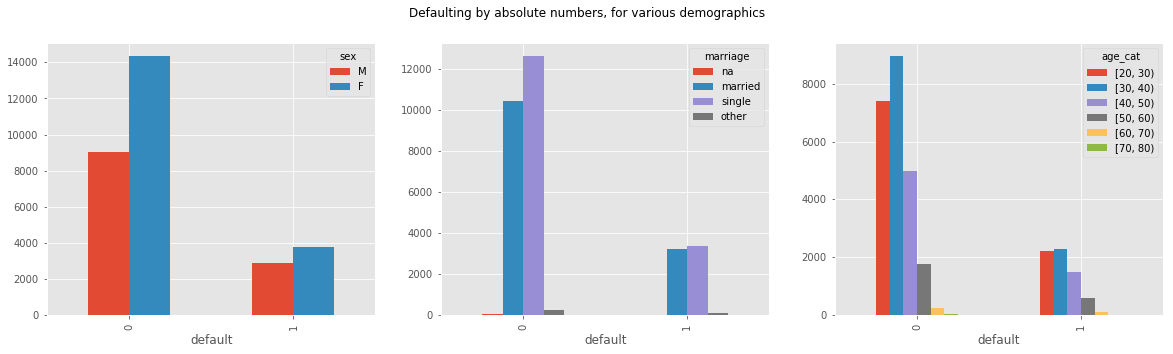

In [22]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(20,5)
fig.suptitle('Defaulting by absolute numbers, for various demographics')

d = data.groupby(['default', 'sex']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[0])

d = data.groupby(['default', 'marriage']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[1])

d = data.groupby(['default', 'age_cat']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[2])

##### Statistics relative to the population

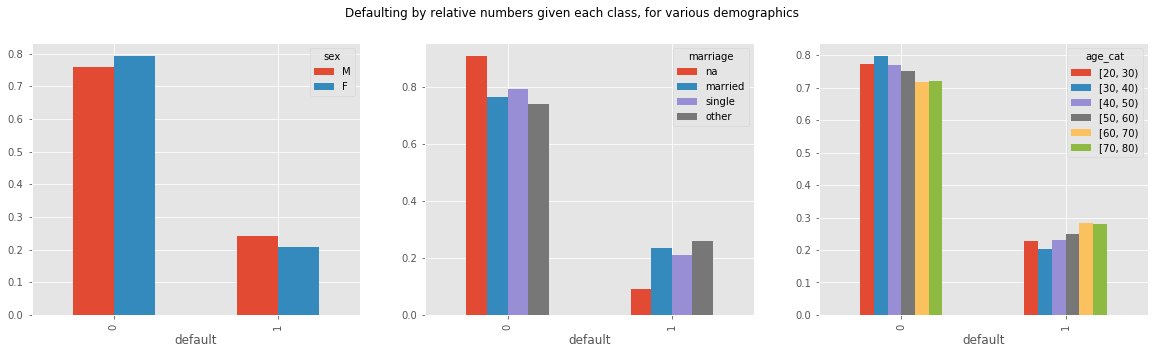

In [23]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(20,5)
fig.suptitle('Defaulting by relative numbers given each class, for various demographics')

d = data.groupby(['default', 'sex']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[0])

d = data.groupby(['default', 'marriage']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[1])

d = data.groupby(['default', 'age_cat']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[2])

## Week 2:- ETL and Feature Creation

### Feature engineering

Extracted few new features by applying transformation techniques such as mean, standard deviation and logs etc.

In [24]:
# help func
def selcols(prefix, a=1, b=6):
    return [prefix+str(i) for i in np.arange(a,b+1)]

In [25]:
# average and standard deviation payment status
data['pay_avg'] = data[selcols('pay_')].mean(axis=1)
data['pay_std'] = data[selcols('pay_')].std(axis=1)

In [26]:
# average payment
data['pay_amt_avg']     = data[selcols('pay_amt')].mean(axis=1)

# log of average
data['pay_amt_avg_log'] = data['pay_amt_avg'].apply(lambda x: log(x+1))

#amounts relative to the average payment
for i in np.arange(1,7):
    data['pay_relamt'+str(i)] = data['pay_amt'+str(i)]/data['pay_amt_avg']

# log of payments
for i in np.arange(1,7):
    data['pay_amt_log'+str(i)] = data['pay_amt'+str(i)].apply(lambda x: log(x+1))

In [27]:
# average bill
data['bill_amt_avg'] = data[selcols('bill_amt')].mean(axis=1)
data['bill_amt_avg_log'] = data['bill_amt_avg'].apply(lambda x: log(x+1) if x>0 else 0)

# bill sign as a separate feature
for i in np.arange(1,7):
    data['bill_amt_sign'+str(i)] = data['bill_amt'+str(i)].apply(lambda x: float(x>0))
    
# bill log as a separate feature (0 if bill is negative)
for i in np.arange(1,7):
    data['bill_amt_log'+str(i)] = data['bill_amt'+str(i)].apply(lambda x: log(x+1) if x>0 else 0)
    
#bill amounts relative to the limit
for i in np.arange(1,7):
    data['bill_relamt'+str(i)] = data['bill_amt'+str(i)]/data['limit_bal']

In [28]:
#log of credit limit
data['limit_bal_log'] = data['limit_bal'].apply(lambda x: log(x+1))
data['limit_bal_cat'] = pd.cut(data['limit_bal'], range(0, int(1e6), 10000), right=False)

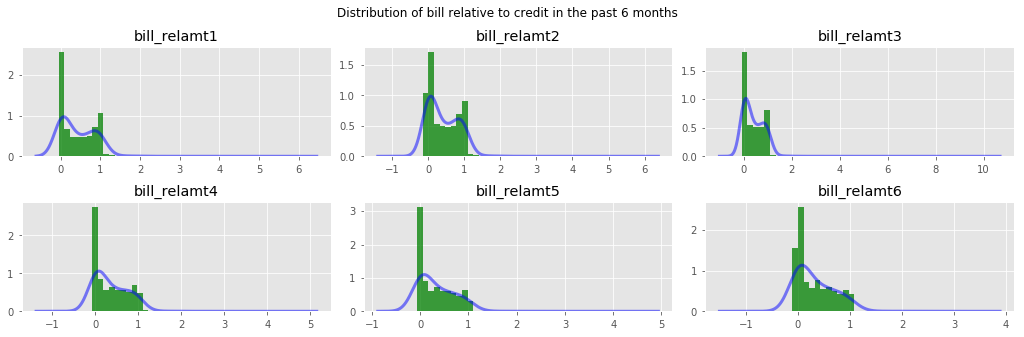

In [29]:
warnings.filterwarnings("ignore")
pattern = re.compile("^bill_relamt[0-9]+$")
columns = [ x for x in data.columns if (pattern.match(x))]

fig, ax = plt.subplots(2,3)
fig.set_size_inches(15,5)
fig.suptitle('Distribution of bill relative to credit in the past 6 months')

for i in range(len(columns)):
    row,col = int(i/3), i%3

    d = data[columns[i]]
    # the histogram of the data
    n, bins, patches = ax[row,col].hist(d, 50, normed=1, facecolor='green', alpha=0.75)

    # kernel density estimation
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(d.values.reshape(-1, 1))
    x_grid = np.linspace(d.min(), d.max(), 1000)
    log_pdf = kde.score_samples(x_grid.reshape(-1, 1))

    # add the density line
    ax[row,col].plot(x_grid, np.exp(log_pdf), color='blue', alpha=0.5, lw=3)
    ax[row,col].set_title(columns[i])

plt.tight_layout(pad=3.0, w_pad=0.5, h_pad=1.0)
plt.show()

##### Generate Train and Test Matrix from the attributes

In [31]:
formula  = 'default ~ '

# original features
formula += 'C(sex) + C(marriage) +  C(education) + age'
formula += '+' + '+'.join(selcols('pay_'))

#### engineered / normalized features

# categorical age and credit limit (binned)
formula += '+' + 'C(age_cat)'
formula += '+' + 'C(limit_bal_cat) + limit_bal_log'

#pay delays
formula += '+' + 'pay_avg + pay_std'
    
#pay_amt
formula += '+' + 'pay_amt_avg_log'
formula += '+' + '+'.join(selcols('pay_relamt'))
formula += '+' + '+'.join(selcols('pay_amt_log'))

# bill amounts
formula += '+' + 'bill_amt_avg_log'
formula += '+' + '+'.join(selcols('bill_relamt'))
formula += '+' + '+'.join(selcols('bill_amt_sign'))
formula += '+' + '+'.join(selcols('bill_amt_log'))

y, X = dmatrices(formula, data=data, return_type='dataframe')
y = y.iloc[:, 1]

In [32]:
X.head()

,Intercept,C(sex)[T.F],C(marriage)[T.married],C(marriage)[T.single],C(marriage)[T.other],C(education)[T.1],C(education)[T.2],C(education)[T.3],C(education)[T.4],C(education)[T.5],...,bill_amt_sign3,bill_amt_sign4,bill_amt_sign5,bill_amt_sign6,bill_amt_log1,bill_amt_log2,bill_amt_log3,bill_amt_log4,bill_amt_log5,bill_amt_log6
0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,8.272315,8.040125,6.536692,0.000000,0.000000,0.000000
1,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,7.894691,7.453562,7.894691,8.093462,8.147867,8.090096
2,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,10.283293,9.548811,9.514880,9.570250,9.612400,9.651816
3,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,10.757711,10.783819,10.805517,10.251147,10.273671,10.293771
4,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,9.061608,8.643121,10.486708,9.949464,9.859901,9.859118


##### Visualization: Confusion matrices and AUC curves

In [33]:
def plot_cm(ax, y_true, y_pred, classes, title, th=0.5, cmap=plt.cm.Blues):
    # Returns Confusion Matrix
    y_pred_labels = (y_pred>th).astype(int)
    
    cm = confusion_matrix(y_true, y_pred_labels)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')


def plot_auc(ax, y_train, y_train_pred, y_test, y_test_pred, th=0.5):
    # Retunrs AUC Curves
    y_train_pred_labels = (y_train_pred>th).astype(int)
    y_test_pred_labels  = (y_test_pred>th).astype(int)

    fpr_train, tpr_train, _ = roc_curve(y_train,y_train_pred)
    roc_auc_train = auc(fpr_train, tpr_train)
    acc_train = accuracy_score(y_train, y_train_pred_labels)

    fpr_test, tpr_test, _ = roc_curve(y_test,y_test_pred)
    roc_auc_test = auc(fpr_test, tpr_test)
    acc_test = accuracy_score(y_test, y_test_pred_labels)

    ax.plot(fpr_train, tpr_train)
    ax.plot(fpr_test, tpr_test)

    ax.plot([0, 1], [0, 1], 'k--')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve')
    
    train_text = 'train acc = {:.3f}, auc = {:.2f}'.format(acc_train, roc_auc_train)
    test_text = 'test acc = {:.3f}, auc = {:.2f}'.format(acc_test, roc_auc_test)
    ax.legend([train_text, test_text])

##### Feature selection

Feature selection is a technique where we choose those features in our data that contribute most to the target variable. In other words we choose the best predictors for the target variable.

The classes in the **sklearn.feature_selection** module can be used for feature selection/dimensionality reduction on sample sets, either to improve estimators’ accuracy scores or to boost their performance on very high-dimensional datasets. We can get the following benefits by using this module:

* Reduces Overfitting: Less redundant data means less possibility of making decisions based on redundant data/noise.
* Improves Accuracy: Less misleading data means modeling accuracy improves.
* Reduces Training Time: Less data means that algorithms train faster.

In [34]:
# Take best 25 features/predictors
selector = SelectKBest(f_classif, 25)
selector.fit(X, y)

SelectKBest(k=25, score_func=<function f_classif at 0x0000027EF58FED90>)

We got the following best 25 features from the method

In [35]:
top_indices = np.nan_to_num(selector.scores_).argsort()[-25:][::-1]
selector.scores_[top_indices]
list(X.columns[top_indices])

['pay_1[T.2]',
 'pay_2[T.2]',
 'pay_avg',
 'pay_3[T.2]',
 'pay_4[T.2]',
 'pay_5[T.2]',
 'pay_std',
 'pay_6[T.2]',
 'pay_1[T.0]',
 'limit_bal_log',
 'pay_amt_log1',
 'pay_amt_avg_log',
 'bill_relamt6',
 'pay_2[T.0]',
 'bill_relamt5',
 'bill_relamt4',
 'pay_amt_log2',
 'bill_relamt3',
 'bill_relamt2',
 'pay_amt_log3',
 'pay_1[T.3]',
 'bill_relamt1',
 'pay_2[T.3]',
 'pay_3[T.0]',
 'pay_amt_log4']

##### Feature scaling

Many machine learning algorithms perform better when numerical input variables are scaled to a standard range. This includes algorithms that use a weighted sum of the input, like linear regression, and algorithms that use distance measures, like k-nearest neighbors.
The two most popular techniques for scaling numerical data prior to modeling are normalization and standardization. **Normalization** scales each input variable separately to the range 0-1, which is the range for floating-point values where we have the most precision. **Standardization** scales each input variable separately by subtracting the mean (called centering) and dividing by the standard deviation to shift the distribution to have a mean of zero and a standard deviation of one.

We can apply the **MinMaxScaler** to the dataset directly to normalize the input variables.

In [36]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [37]:
preprocess = Pipeline([('anova', selector), ('scale', scaler)])
preprocess.fit(X,y)

X_scaled = preprocess.transform(X)

##### Model selection and validation

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [42]:
def CMatrix(CM, labels=['Not Default','Default']):
    df = pd.DataFrame(data=CM, index=labels, columns=labels)
    df.index.name='TRUE'
    df.columns.name='Prediction'
    df.loc['Total'] = df.sum()
    df['Total'] = df.sum(axis=1)
    return df

## Week 3 & 4:- Model Definition and Training, Model Evaluation, Tuning, Deployment and Documentation

**Logistic Regression**

* Used for Binary classification and Based on Probability
* Outputs have a probabilistic interpretation, and the algorithm can be regularized to avoid over fitting
* The conditional probability p of class belongs to 1 if probability >= threshold (default 0.5) else it belongs to class 0

**Random Forest**

* It is an ensembled model built on decision trees
* It builds multiple decision trees and merges them together to get a more accurate and stable prediction

**Artificial Neural Network**

* Neural Network is used with backpropagation algorithm to select optimum weights of predictors. The following architecture and hyper parameters used.

1. Input Layer 26 Hidden Layer 26 Output Layer 1
2. Epochs 10 Optimizer ADAM Activation function ReLU and Sigmoid Loss function Binary cross entropy

##### Dummy Classifier

In [49]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

In [50]:
print("Accuracy of the dummy classifier: ", dummy_clf.score(X_test, y_test))

Accuracy of the dummy classifier:  0.7931396569828492


##### Logistic regression

In [51]:
# Create logistic regression object
LR_clf = linear_model.LogisticRegression()

# Train the model using the training sets
LR_clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

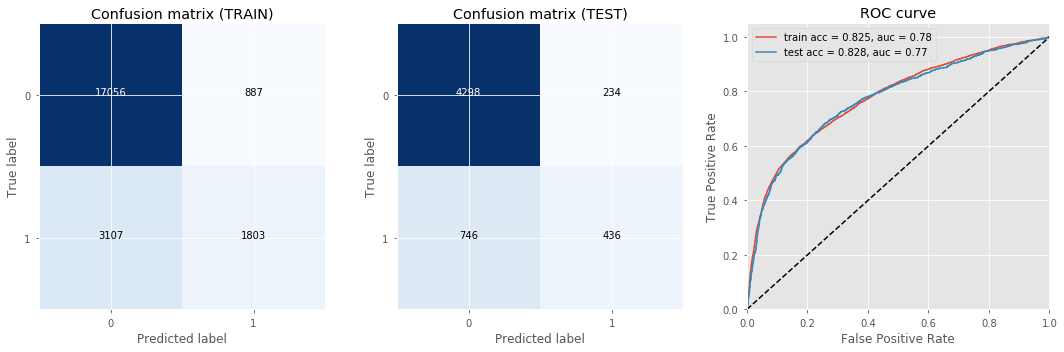

In [52]:
y_train_pred = LR_clf.predict_proba(X_train)[:,1]
y_test_pred = LR_clf.predict_proba(X_test)[:,1]

threshold = 0.5

fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)

plot_cm(ax[0],  y_train, y_train_pred, [0,1], 'Confusion matrix (TRAIN)', threshold)
plot_cm(ax[1],  y_test, y_test_pred,   [0,1], 'Confusion matrix (TEST)', threshold)
plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()

##### Logistic Regression with Threshold 0.2

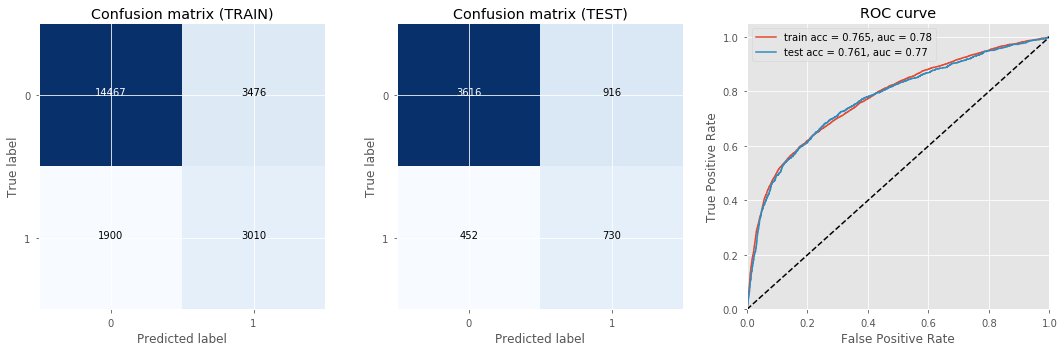

In [53]:
y_train_pred = LR_clf.predict_proba(X_train)[:,1]
y_test_pred = LR_clf.predict_proba(X_test)[:,1]

threshold = 0.2

fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)

plot_cm(ax[0],  y_train, y_train_pred, [0,1], 'Confusion matrix (TRAIN)', threshold)
plot_cm(ax[1],  y_test, y_test_pred,   [0,1], 'Confusion matrix (TEST)', threshold)
plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()

In [54]:
CMatrix(confusion_matrix(y_pred=[1 if i > threshold else 0 for i in y_test_pred], y_true=y_test))

Prediction,Not Default,Default,Total
TRUE,,,
Not Default,3616,916,4532
Default,452,730,1182
Total,4068,1646,5714


##### Random Forest

In [55]:
RF_clf = RandomForestClassifier(n_estimators=500, min_samples_leaf=5)
RF_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

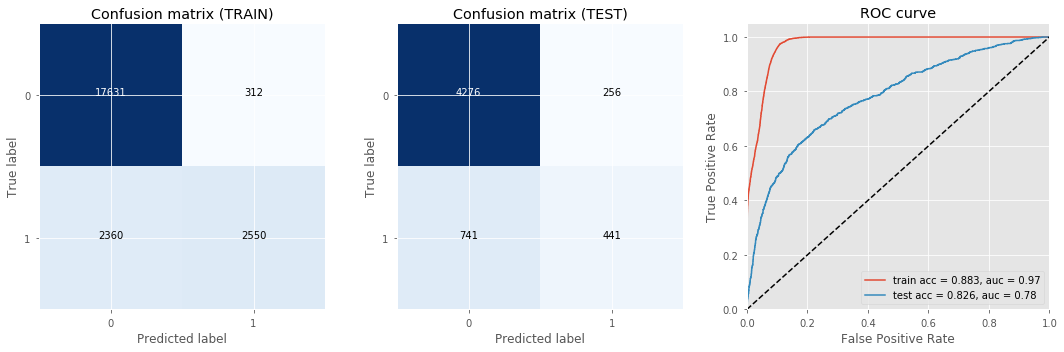

In [56]:
threshold = 0.5
y_train_pred = RF_clf.predict_proba(X_train)[:,1]
y_test_pred = RF_clf.predict_proba(X_test)[:,1]

fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)

plot_cm(ax[0],  y_train, y_train_pred, [0,1], 'Confusion matrix (TRAIN)', threshold)
plot_cm(ax[1],  y_test, y_test_pred,   [0,1], 'Confusion matrix (TEST)', threshold)
plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()

##### Boosting

In [57]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [58]:
num_round = 5
evallist  = [(dtest,'eval'), (dtrain,'train')]
param = {'objective':'binary:logistic', 'silent':1, 'eval_metric': ['error', 'logloss']}

bst = xgb.train( param, dtrain, num_round, evallist )

[0]	eval-error:0.178159	eval-logloss:0.572755	train-error:0.167505	train-logloss:0.568834
[1]	eval-error:0.178509	eval-logloss:0.508294	train-error:0.165624	train-logloss:0.501548
[2]	eval-error:0.176234	eval-logloss:0.471332	train-error:0.165011	train-logloss:0.461776
[3]	eval-error:0.175884	eval-logloss:0.449392	train-error:0.164617	train-logloss:0.437177
[4]	eval-error:0.175359	eval-logloss:0.435512	train-error:0.162998	train-logloss:0.421064


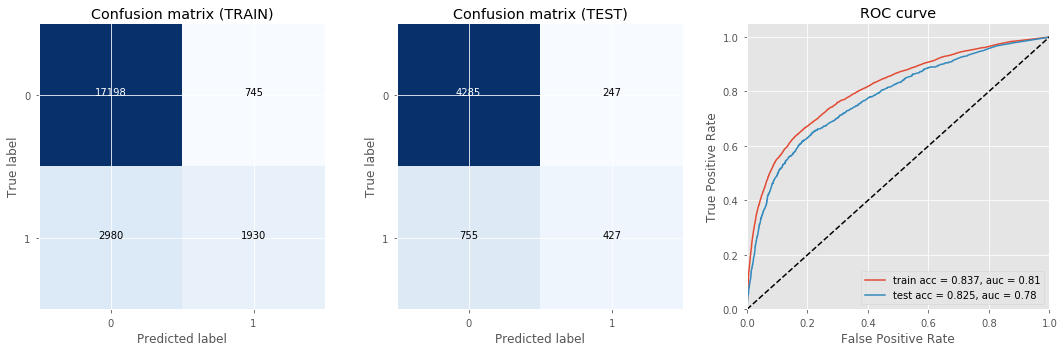

In [59]:
threshold = 0.5
y_train_pred = bst.predict(dtrain)
y_test_pred = bst.predict(dtest)

fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)

plot_cm(ax[0],  y_train, y_train_pred, [0,1], 'Confusion matrix (TRAIN)', threshold)
plot_cm(ax[1],  y_test, y_test_pred,   [0,1], 'Confusion matrix (TEST)', threshold)
plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()

##### Feed forward deep neural nets

In [60]:
input_dim = X_train.shape[1]

model = Sequential()
model.add(Dense(256, input_shape=(input_dim,), activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(1,  activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


In [61]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [62]:
from keras.callbacks import Callback

class BatchLogger(Callback):
    def on_train_begin(self, epoch, logs={}):
        self.log_values = {}
        for k in self.params['metrics']:
            self.log_values[k] = []

    def on_epoch_end(self, batch, logs={}):
        for k in self.params['metrics']:
            if k in logs:
                self.log_values[k].append(logs[k])
    
    def get_values(self, metric_name, window):
        d =  pd.Series(self.log_values[metric_name])
        return d.rolling(window,center=False).mean()

bl = BatchLogger()

In [63]:
history = model.fit(
              np.array(X_train), np.array(y_train),
              batch_size=25, epochs=10, verbose=1, callbacks=[bl],
              validation_data=(np.array(X_test), np.array(y_test)))

Instructions for updating:
Use tf.cast instead.
Train on 22853 samples, validate on 5714 samples
Epoch 1/10
22853/22853 [==============================] - 5s 230us/step - loss: 0.4480 - acc: 0.8138 - val_loss: 0.4281 - val_acc: 0.8224
Epoch 2/10
22853/22853 [==============================] - 4s 156us/step - loss: 0.4293 - acc: 0.8251 - val_loss: 0.4225 - val_acc: 0.8250
Epoch 3/10
22853/22853 [==============================] - 3s 146us/step - loss: 0.4264 - acc: 0.8263 - val_loss: 0.4206 - val_acc: 0.8297
Epoch 4/10
22853/22853 [==============================] - 3s 146us/step - loss: 0.4247 - acc: 0.8268 - val_loss: 0.4196 - val_acc: 0.8288
Epoch 5/10
22853/22853 [==============================] - 3s 151us/step - loss: 0.4236 - acc: 0.8275 - val_loss: 0.4222 - val_acc: 0.8288
Epoch 6/10
22853/22853 [==============================] - 4s 170us/step - loss: 0.4234 - acc: 0.8272 - val_loss: 0.4197 - val_acc: 0.8287
Epoch 7/10
22853/22853 [==============================] - 3s 139us/step - l

In [64]:
score = model.evaluate(np.array(X_test), np.array(y_test), verbose=0)
print('Test log loss:', score[0])
print('Test accuracy:', score[1])

Test log loss: 0.4193731993697597
Test accuracy: 0.8270913545051404


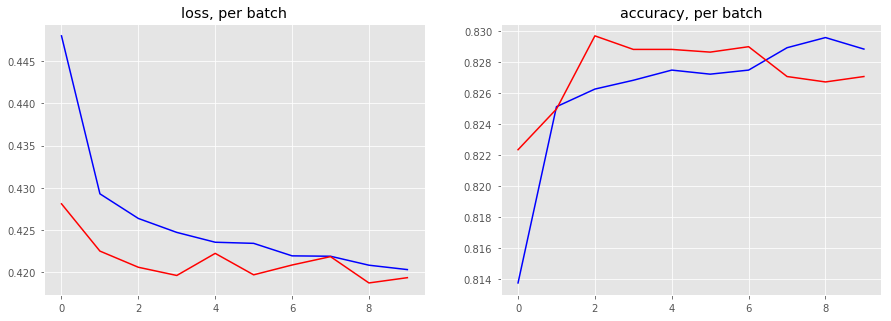

In [65]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.title('loss, per batch')
plt.plot(bl.get_values('loss',1), 'b-', label='train');
plt.plot(bl.get_values('val_loss',1), 'r-', label='test');

plt.subplot(1, 2, 2)
plt.title('accuracy, per batch')
plt.plot(bl.get_values('acc',1), 'b-', label='train');
plt.plot(bl.get_values('val_acc',1), 'r-', label='test');
plt.show()

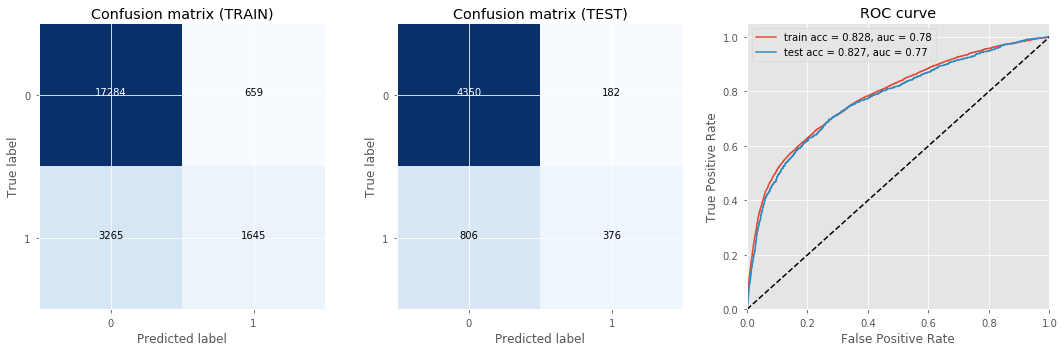

In [66]:
y_train_pred = model.predict_on_batch(np.array(X_train))[:,0]
y_test_pred = model.predict_on_batch(np.array(X_test))[:,0]

fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)

plot_cm(ax[0], y_train, y_train_pred, [0,1], 'Confusion matrix (TRAIN)')
plot_cm(ax[1], y_test, y_test_pred, [0,1], 'Confusion matrix (TEST)')

plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred)
    
plt.tight_layout()
plt.show()

##### Model Deployment

Model deployment comes in many shapes. The key to everything is that the business insights that result from the model are made available to stakeholders. This can happen in various ways. At the simplest level a PDF report is generated (e.g. using a jupyter notebook) and handed over to business stakeholders.